In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
from pathlib import Path
import pandas as pd

In [31]:
from kinodata.data.data_split import RandomSplit, Split
from kinodata.data.cold_split import ColdSplit
from kinodata.data.utils.similarity import BLOSUMSubstitutionSimilarity, pairwise_tanimoto_similarity
from kinodata.data.utils.scaffolds import generate_scaffolds
from kinodata.data.utils.pocket_sequence_klifs import add_pocket_sequence
from kinodata.data.utils.cluster import AffinityPropagation
from kinodata.data.dataset import KinodataDocked

In [89]:
dataset = KinodataDocked()

Separating data objects...


100%|██████████| 52208/52208 [00:12<00:00, 4200.43it/s]


Applying post filter...


100%|██████████| 52208/52208 [00:00<00:00, 79379.27it/s]


In [90]:
len(dataset)

40992

In [96]:
PATH = Path("data") / "splits"
SEEDS = tuple(range(5))
TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1
dataset = KinodataDocked()
data_source = dataset.df
idents = [data.ident for data in dataset]

Separating data objects...


100%|██████████| 52208/52208 [00:11<00:00, 4532.13it/s]


Applying post filter [FilterActivityType(allowed=pIC50), FilterActivityScore(threshold=0)]...


100%|██████████| 52208/52208 [00:00<00:00, 75355.01it/s]


Filter removed 11216 items.
Reading data frame..
Checking for missing pocket mol2 files...


100%|██████████| 2439/2439 [00:00<00:00, 27600.21it/s]


In [87]:
# data_source is not yet filtered!
data_source.shape[0], len(dataset)

52239

In [101]:
data_source = data_source.set_index("ident").loc[idents]

In [102]:
def path_to_split(kind: str, seed: int) -> Path:
    return PATH / kind / f"seed_{seed}.csv"

def pocket_split_path(seed: int) -> Path:
    return path_to_split("pocket", seed)
                         
def random_split_path(seed: int) -> Path:
    return path_to_split("random", seed)

def scaffold_split_path(seed: int) -> Path:
    return path_to_split("scaffold", seed)

## Generate random splits

In [103]:
index_to_ident = {
    i: data.ident for i, data in enumerate(dataset)
}

In [104]:
random_split = RandomSplit(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)
for seed in SEEDS:
    split = random_split(dataset, seed)
    # idents are more persistent/robust than data object index
    split = split.remap_index(index_to_ident)
    split.to_data_frame().to_csv(PATH / "random" / f"seed_{seed}.csv")
    

## Generate scaffold splits

In [75]:
scaffold_path = PATH / "scaffold" / "scaffolds.csv"
if scaffold_path.exists():
    df_scaffold = pd.read_csv(scaffold_path)
else:
    df_scaffold = generate_scaffolds(dataset)
    df_scaffold.to_csv(scaffold_path, index=False)

In [76]:
scaffold_similarities = pairwise_tanimoto_similarity(df_scaffold["scaffold"].unique())

In [85]:
scaffold_similarities.shape

(7895, 7895)

In [105]:
df_scaffold

,Unnamed: 0,ident,scaffold
0,0,37861,C1CCC(CC2CCC(C3CCCCC3)C2)CC1
1,1,40692,C1CCC(CC2CCC(C3CC(C4CCCC4)C4CCCCC34)CC2)CC1
2,2,41985,C1CCC(CC2CCC(C3CCC4CCCCC43)CC2)CC1
3,3,42689,C1CCC(CC2CCC(C3CCCCC3)C2)CC1
4,4,44685,C1CCC(CC2CCCC3CCCCC32)CC1
...,...,...,...
40987,40987,23316574,CC(CC1CCCC(C2CCCC2)C1)C1CCCCC1
40988,40988,23316575,CC(CC1CCCC(C2CCCC2)C1)C1CCCC2CCCCC21
40989,40989,23316576,CC(CC1CCCC(C2CCCC2)C1)C1CCCC2CCCCC21
40990,40990,23316582,CC(CC1CCCC(C2CCCC2)C1)C1CCCCC1


In [93]:
scaffold_split = ColdSplit(TRAIN_SIZE, VAL_SIZE, TEST_SIZE, attribute_key="scaffold", clustering=None)
for seed in SEEDS:
    split = scaffold_split(df_scaffold, seed, scaffold_similarities)
    split.to_data_frame().to_csv(PATH / "scaffold" / f"seed_{seed}.csv", index=False)
    

## Pocket Splits

In [113]:
pocket_path = PATH / "pocket" / "pocket_sequences.csv"
if pocket_path.exists():
    df_pocket = pd.read_csv(pocket_path)
else:
    df_pocket = add_pocket_sequence(data_source, pocket_sequence_key="structure.pocket_sequence")
    df_pocket[["ident", "structure.pocket_sequence"]].to_csv(pocket_path, index=False)

df_pocket["ident"] = df_pocket["ident"].astype(int)

In [114]:
idents = [int(i) for i in idents]

In [115]:
df_pocket = df_pocket.set_index("ident")
df_pocket = df_pocket.loc[idents]

In [123]:
df_pocket["ident"] = df_pocket.index

In [117]:
pocket_similarities = BLOSUMSubstitutionSimilarity()(df_pocket["structure.pocket_sequence"].unique())

In [118]:
pocket_similarities.shape

(634, 634)

In [124]:
pocket_split = ColdSplit(TRAIN_SIZE, VAL_SIZE, TEST_SIZE, attribute_key="structure.pocket_sequence")
for seed in SEEDS:
    split = pocket_split(df_pocket, seed, pocket_similarities)
    split.to_data_frame().to_csv(PATH / "pocket" / f"seed_{seed}.csv", index=False)

In [293]:
df_pocket_cluster = pocket_split.clustering(df_pocket, pocket_split.attribute_key, pocket_similarities)

In [268]:
index, count = np.unique(pocket_split.clustering.model.labels_, return_counts=True)

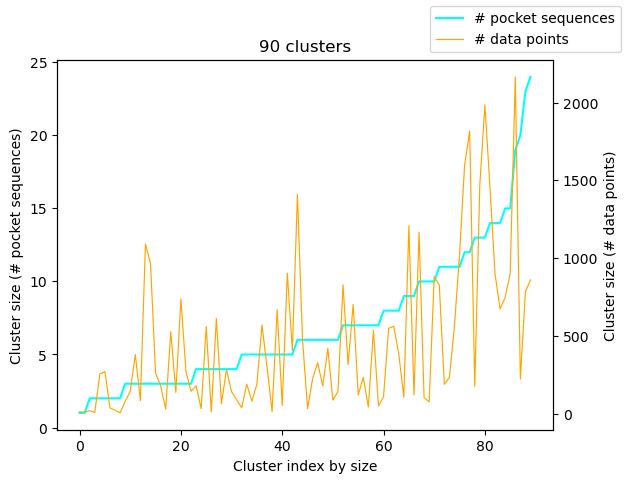

In [291]:
fig, ax = plt.subplots()
sort_idx = np.argsort(count)
ax.plot(count[sort_idx], label="# pocket sequences", color="cyan")
ax1 = ax.twinx()
ax1.plot(np.arange(val.shape[0]), val.values[sort_idx], label="# data points", color="orange", linewidth=0.85)
ax.set_title(f"{val.shape[0]} clusters")
ax.set_xlabel("Cluster index by size")
ax.set_ylabel("Cluster size (# pocket sequences)")
ax1.set_ylabel("Cluster size (# data points)")
fig.legend()

Text(0, 0.5, 'Number of ')

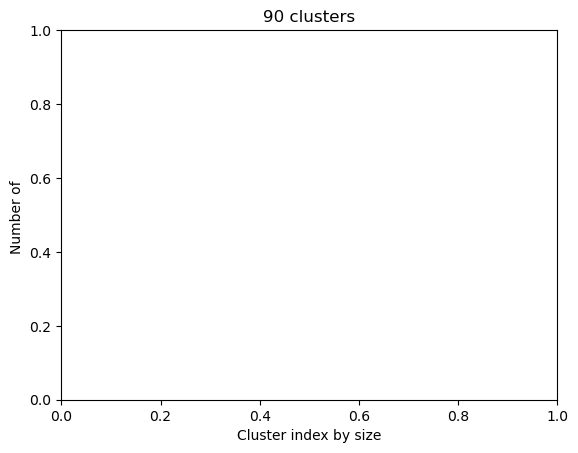

In [270]:
val = model.groupby("cluster_index").size()
plt.title(f"{val.shape[0]} clusters")
plt.xlabel("Cluster index by size")
plt.ylabel("Number of ")

In [292]:
pock

Index(['assays.chembl_id', 'target_dictionary.chembl_id',
       'molecule_dictionary.chembl_id', 'molecule_dictionary.max_phase',
       'activities.standard_type', 'activities.standard_value',
       'activities.standard_units', 'compound_structures.canonical_smiles',
       'compound_structures.standard_inchi', 'component_sequences.sequence',
       'assays.confidence_score', 'docs.chembl_id', 'docs.year',
       'docs.authors', 'UniprotID', 'docking.chemgauss_score',
       'docking.posit_probability', 'docking.duration',
       'similar.klifs_structure_id', 'molecule', 'pocket_mol2_file', 'ident'],
      dtype='object')

In [420]:

pocket_split_klifs_data = pd.merge(df_pocket_cluster.set_index("ident"), data_source[["ident", "similar.klifs_structure_id"]].set_index("ident"), left_index=True, right_index=True)
pocket_split_klifs_data =  pocket_split_klifs_data.reset_index().drop(columns="Unnamed: 0").rename(columns={"similar.klifs_structure_id": "klifs.structure_id"})
pocket_split_klifs_data.to_csv("pocket_clusters_with_klifs_full.csv", index=False)

In [421]:
pocket_split_klifs_data = pocket_split_klifs_data.groupby("klifs.structure_id")["cluster_index"].max().reset_index()

In [358]:
import requests
import json
kinase_ids = {
    "klifs.structure_ids": [],
    "kinase_ID": []
}
for _, row in pocket_split_klifs_data.iterrows():
    resp = requests.get(
                "https://klifs.net/api_v2/structure_list",
                params={"structure_ID": row["klifs.structure_id"]},
    )
    resp.raise_for_status()
    content = json.loads(resp.content)[0]
    kinase_ids["klifs.structure_ids"].append(row["klifs.structure_id"])
    kinase_ids["kinase_ID"].append(content["kinase_ID"])

In [359]:
kinase_ids = pd.DataFrame(kinase_ids)

In [370]:
kinase_ids = kinase_ids.rename(columns={"klifs.structure_ids": "klifs.structure_id"})

In [422]:
kinase_ids.columns, pocket_split_klifs_data.columns

(Index(['klifs.structure_id', 'kinase_ID'], dtype='object'),
 Index(['klifs.structure_id', 'cluster_index'], dtype='object'))

In [423]:
pocket_split_klifs_data = pd.merge(pocket_split_klifs_data, kinase_ids, on="klifs.structure_id")
pocket_split_klifs_data

,klifs.structure_id,cluster_index,kinase_ID
0,1,62,415
1,5,58,474
2,13,58,474
3,14,58,474
4,16,58,474
...,...,...,...
2101,14579,38,186
2102,14601,34,160
2103,14606,1,198
2104,14624,17,451


In [399]:
kids = kinase_ids["kinase_ID"].unique()
kids

array([ 415,  474,  424,  482,  393,   55,  367,  458,  372,  333,  425,
        400,  270,  286,  279,  420,  141,  243,  451,  261,   15,  390,
        437,  430,  511,  433,  272,  450,  238,  191,  406,  431,  510,
        218,  462,  432,  392,  470,  281,  518,  150,  370,  161,  435,
         59,  516,  121,  210,   11,  240,  187,  489,  273,  382,  467,
        314,  225,   51,  328,  504,    2,  360,  259,  521,  115,  186,
        442,  391,  189,  207,  466,  449,   39,  160,  491,  128,    1,
         34,  239,  465,  309,    9,  471,  359,  203,  202,  409,  412,
        473,  446,   33,  509,  230,   27,  404,   64,  383,  441,   40,
        454,  394,  247,  428,  481,  480,  436,  227,  312,  268,  483,
        500,  205,  198,  148,  197,  245,  326,  345,  168,  407,  267,
        311,  249,   28,  485,   37,  396,  221,  477,  313,  190,  496,
        140,  498,  512,  505,  223,  490,  527,  277,  143,   10,  419,
        468,  336,  356,  410,  265,  417,  193,  4

In [402]:
kinase_info = defaultdict(list)
for kid in kids:
    resp = requests.get(
        "https://klifs.net/api_v2/kinase_information",
        params={"kinase_ID": kid}
    )
    content = json.loads(resp.content)[0]
    kinase_info["kinase_ID"].append(kid)
    for key in ["name", "group", "subfamily"]:
        kinase_info[key].append(content[key])

In [407]:
kinase_info = pd.DataFrame(kinase_info)

In [424]:
kinase_info.columns, pocket_split_klifs_data.columns

(Index(['kinase_ID', 'name', 'group', 'subfamily'], dtype='object'),
 Index(['klifs.structure_id', 'cluster_index', 'kinase_ID'], dtype='object'))

In [428]:
pocket_split_klifs_data = pd.merge(pocket_split_klifs_data, kinase_info, on="kinase_ID")

In [430]:
pocket_split_klifs_data.to_csv("pocket_klifs_metadata.csv", index=False)

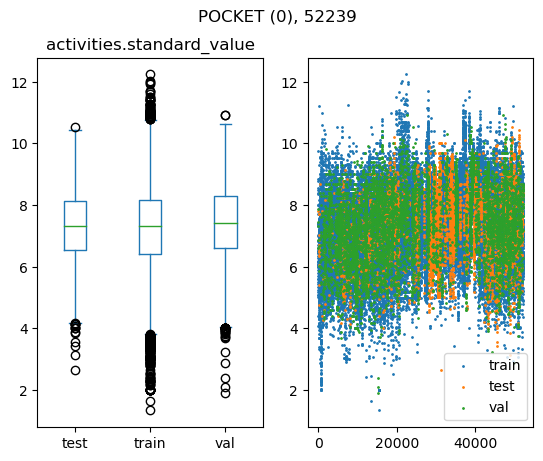

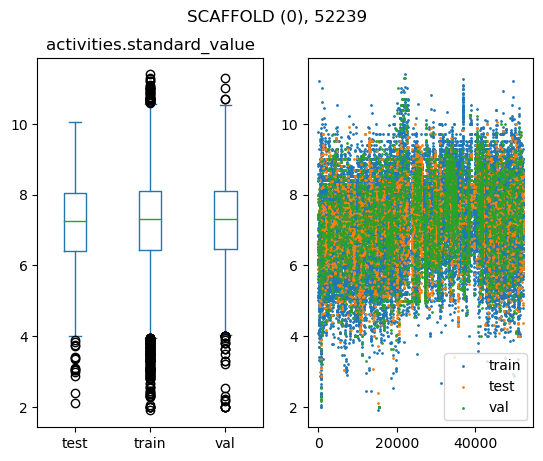

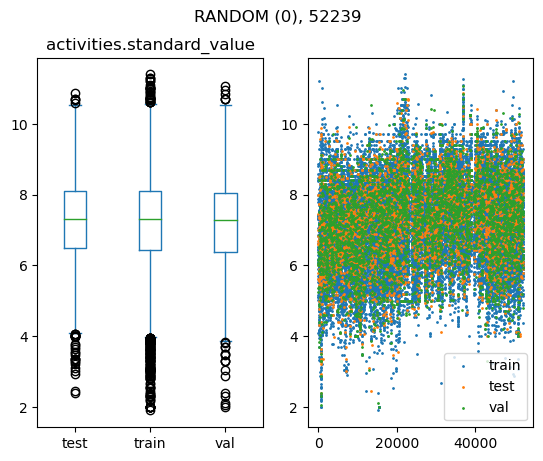

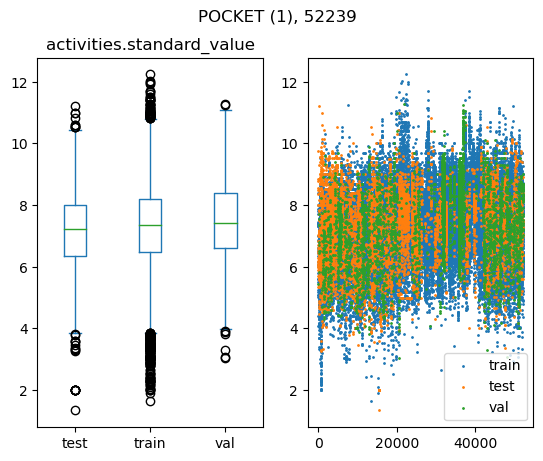

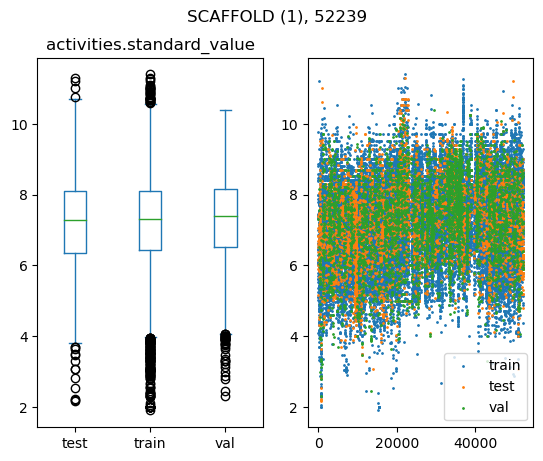

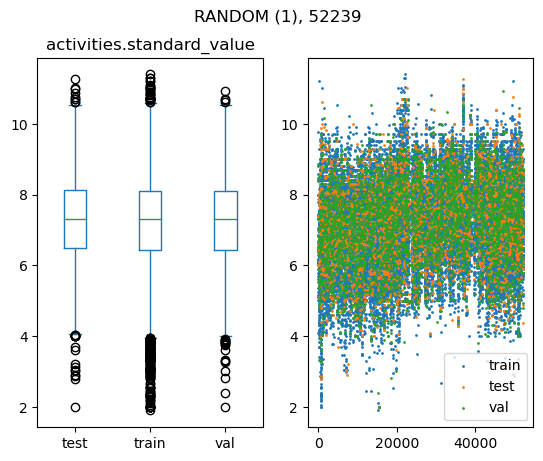

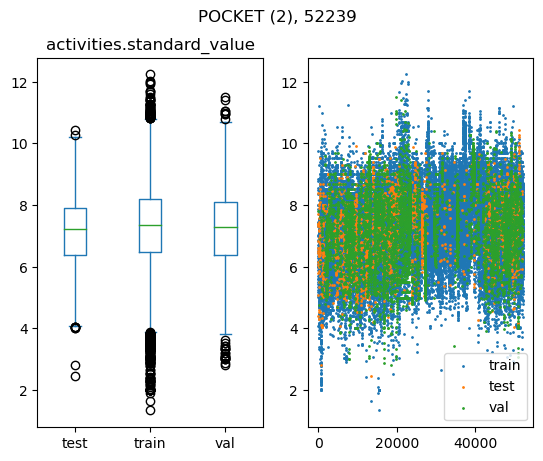

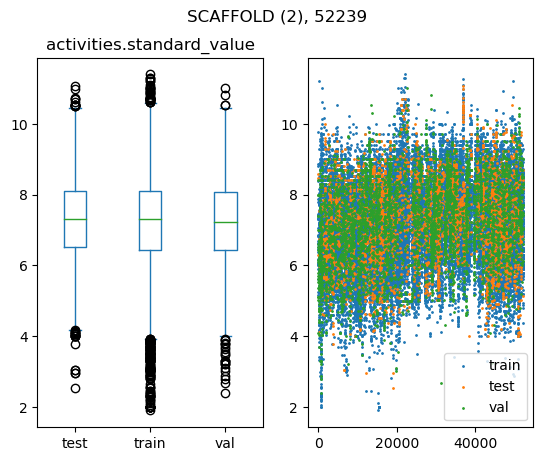

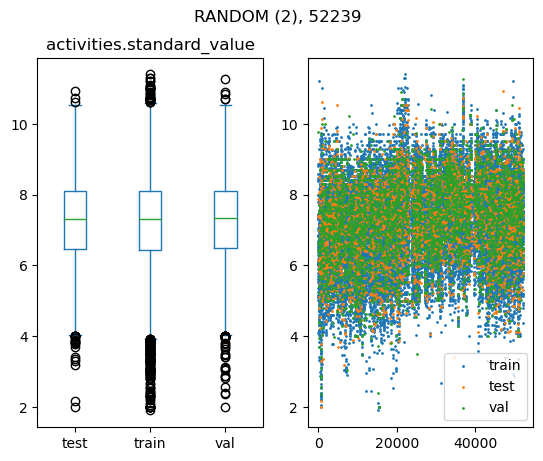

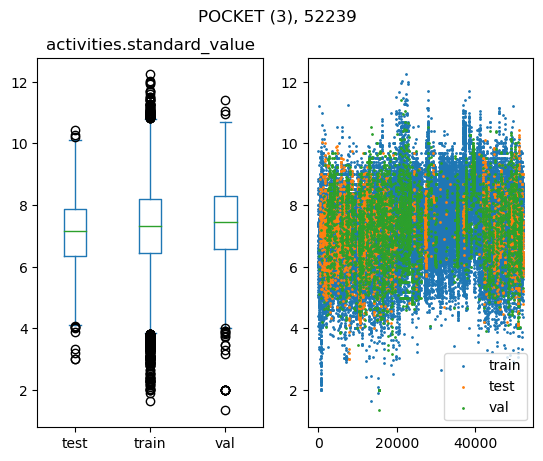

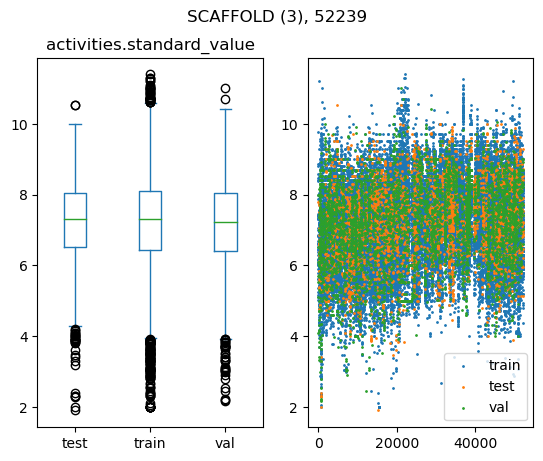

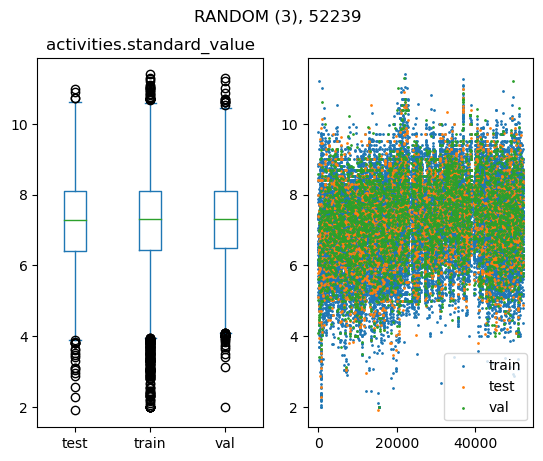

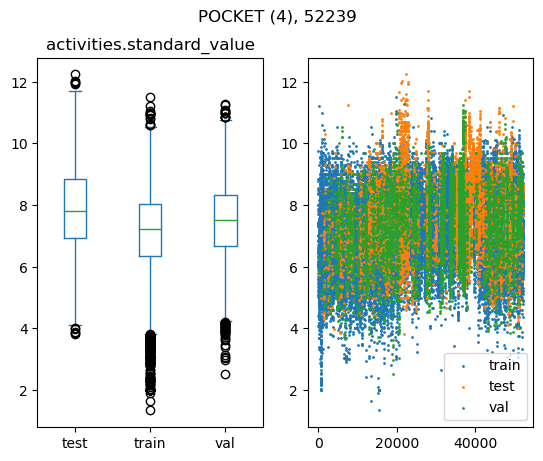

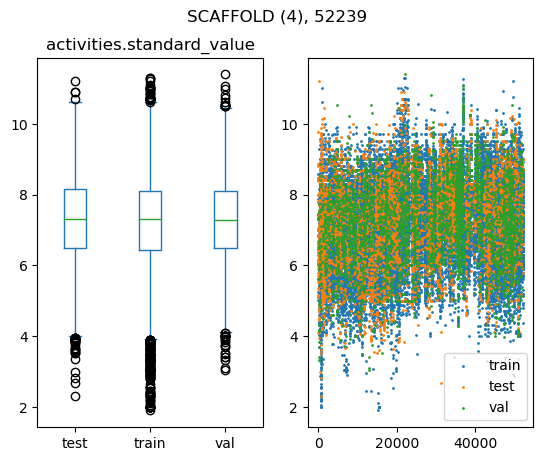

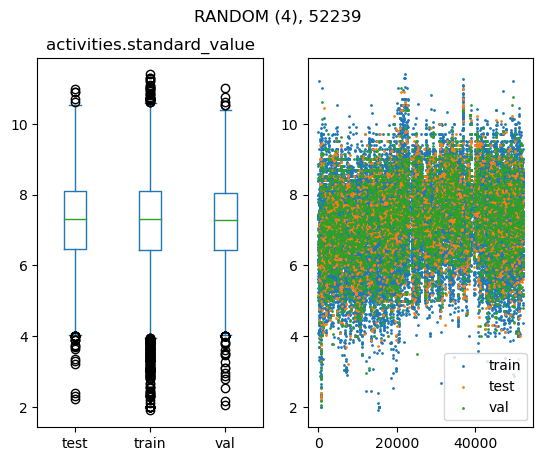

In [95]:
import itertools as itr
import matplotlib.pyplot as plt
import numpy as np

data_source["ident"] = data_source["ident"].astype(int)
for seed, kind in itr.product(SEEDS, ("pocket", "scaffold", "random")):
    split = Split.from_data_frame(pd.read_csv(path_to_split(kind, seed)))
    df_split = pd.merge(split.to_data_frame(), data_source, how="right")
    df_split["activities.standard_value"] = df_split["activities.standard_value"].astype(float)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    df_split[["split", "activities.standard_value"]].plot.box("split", ax=ax1)
    idx = np.arange(df_split.shape[0])
    for label in ("train", "test", "val"):
        mask = df_split.split == label
        data = df_split[mask]
        act = data["activities.standard_value"]
        ax2.scatter(idx[mask], act, label=label, s=1)
    fig.suptitle(f"{kind.upper()} ({seed}), {df_split.shape[0]}")
    plt.legend()
    plt.show()
    

## Visualize Murcko Scaffolds

In [143]:
from rdkit.Chem import Draw, MolFromSmiles

In [146]:
scaffolds = pd.read_csv("data/splits/scaffold/scaffolds.csv")
source = dataset.df
source["ident"] = source["ident"].astype(int)

Index(['C1CCC2CCCC2C1', 'CC1CCCC2CC(C3CCCCC3)CC12',
       'CC(CC1CCCCC1)C1CCC(CC2CCCC(CC3CCCCC3)C2)CC1'],
      dtype='object', name='scaffold')

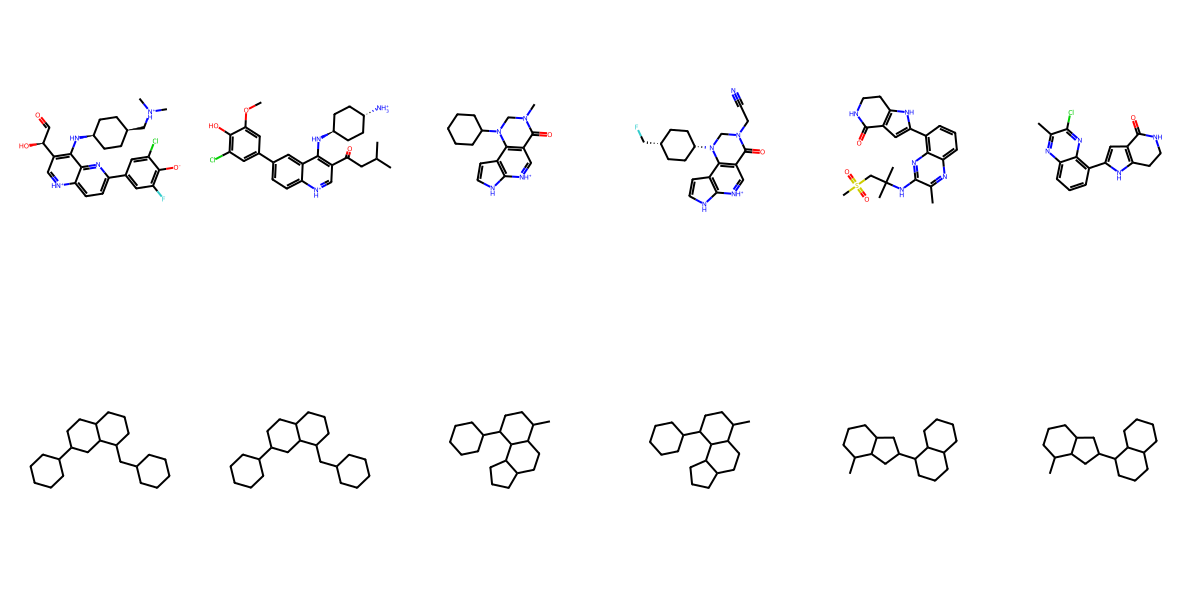

In [229]:
cherries = scaffolds.groupby("scaffold").size().sort_values(ascending=False)[:100].sample(3).index
samples = []
for cherry in cherries:
    samples.append(scaffolds[scaffolds.scaffold == cherry].sample(2))
scafs = pd.concat(samples)
both = pd.merge(scafs, dataset.df, on="ident")
mols = [MolFromSmiles(smiles) for smiles in both["compound_structures.canonical_smiles"]] + [MolFromSmiles(smiles) for smiles in both.scaffold]
Draw.MolsToGridImage(mols, molsPerRow=len(mols) // 2, subImgSize=(200,300))

In [227]:
img = Draw.MolsToGridImage(mols, molsPerRow=len(mols) // 2, subImgSize=(200,300), returnPNG=True)